## Problem Statement
Plant Pathology 2021 - FGVC8 is a [Kaggle competition](https://www.kaggle.com/c/plant-pathology-2021-fgvc8) launched on march 15 2021 and closed on mai 27 2021.

Exploration notebook can be find on [Kaggle](https://www.kaggle.com/xavierbarbier/plant-pathology-2021-fgvc8-eda) and the [full project on Github](https://github.com/xavierbarbier/Plant_Pathology_2021_FGVC8).

The goals of this notebook are:

* Use a distributed approach (TPU) to optimise training time
* Create a sample dataset for training
* Compare differents pre-trained model
* Optimise and tune the selected model
* Train the optimised model on the full dataset

In [1]:
#-------------------
# importing libraries
#-------------------
import tensorflow as tf
from tensorflow.keras import layers
from kaggle_datasets import KaggleDatasets
from tensorflow import keras

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
import shutil
import csv

import matplotlib.image as img

In [2]:
!pip install tensorflow_addons

import tensorflow_addons as tfa

In [3]:
# Define the distributed strategy
AUTO = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path()
print(GCS_DS_PATH)

TRAIN_PATH = GCS_DS_PATH + "/train_images/"

train = pd.read_csv("../input/plant-pathology-2021-fgvc8/train.csv")

train.head()

gs://kds-11c1175113c7e0363eed35763490e88e87d1053fe106cea07cdf154e


,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


# Create a stratify sample

## Split

Text(0.5, 1.0, 'Labels counts')

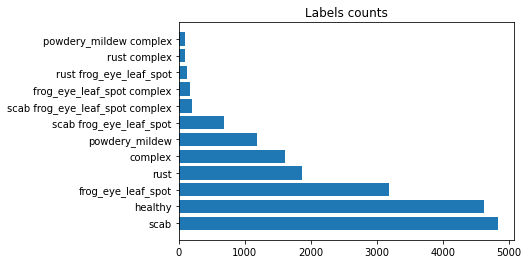

In [5]:
labels_counts = train["labels"].value_counts()

plt.barh(labels_counts.index,labels_counts)
plt.title("Labels counts")

We will use 10% of the full dataset avec use sklearn train_test_split to create our sample.

In [6]:
from sklearn.model_selection import train_test_split


# splitting on labels
X_train, X_test, y_train, y_test = train_test_split(train['image'], train['labels'], test_size=0.1, random_state = 12,
                                                      stratify =  train['labels'] )

# using test set as training sample
data_sample = train.iloc[y_test.index]

print("sample shape")
print(data_sample.shape)

sample shape
(1864, 2)


Text(0.5, 1.0, 'sample labels counts')

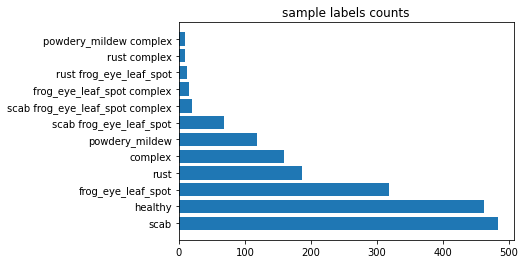

In [7]:
labels_counts = data_sample["labels"].value_counts()

plt.barh(labels_counts.index,labels_counts)
plt.title("sample labels counts")

Sample dataset seems to have same distribution as full dataset

In [8]:
data_sample["path"] = TRAIN_PATH + data_sample["image"]

class_dict = {
    'scab': 0,
    'frog_eye_leaf_spot' : 1,
    'rust' : 2,
    'complex' : 3,
    'powdery_mildew' : 4,
    "healthy" : 5
}
num_classes = len(class_dict)    
class_names = dict([(value, key) for key, value in class_dict.items()])
data_sample["labels"] = data_sample["labels"].map(lambda x : [i for i in x.split(" ")])
#train_df["labels"] = train_df["labels"].map(lambda x : x.split(" "))
data_sample["labels"] = data_sample["labels"].map(lambda x : [class_dict[i] for i in x])

data_sample.head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,image,labels,path
5457,a9be41c0964f8b5e.jpg,[3],gs://kds-11c1175113c7e0363eed35763490e88e87d10...
6169,ad52d5cb3cc4612e.jpg,[5],gs://kds-11c1175113c7e0363eed35763490e88e87d10...
1634,8cda19a8392f24bf.jpg,[1],gs://kds-11c1175113c7e0363eed35763490e88e87d10...
9472,c1ca6b789e0cdb34.jpg,[0],gs://kds-11c1175113c7e0363eed35763490e88e87d10...
15835,f049d452ae92653f.jpg,[1],gs://kds-11c1175113c7e0363eed35763490e88e87d10...


## Data prep

In [9]:
#--------------
#initialize constants
#--------------
HEIGHT,WIDTH = 299,299
CHANNELS = 3
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
SEED = 143
SPLIT = int(0.8*len(data_sample))
AUTO = tf.data.experimental.AUTOTUNE

def process_img(filepath,label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32) 
    
    image = tf.image.resize(image, [HEIGHT,WIDTH])
    return image,label

In [10]:
# Spliting sample data to train and valid set
X_train, X_test, y_train, y_test = train_test_split(data_sample["path"], data_sample['labels'],
                                                    test_size=0.33, random_state = 12,
                                                      stratify =  data_sample['labels'] )

train_ds = pd.concat([X_train, y_train], axis = 1)
valid_ds = pd.concat([X_test, y_test], axis = 1)

files_ls = list(train_ds["path"])
labels = np.zeros((len(train_ds),num_classes))

for i,file in enumerate(train_ds.values):
    labels[i][train_ds.iloc[i]["labels"]] = 1
    
train_ds = tf.data.Dataset.from_tensor_slices((files_ls,labels))
train_ds = train_ds.map(process_img,num_parallel_calls=AUTO)


files_ls = list(valid_ds["path"])
labels = np.zeros((len(valid_ds),num_classes))

for i,file in enumerate(valid_ds.values):
    labels[i][valid_ds.iloc[i]["labels"]] = 1
    
val_ds = tf.data.Dataset.from_tensor_slices((files_ls,labels))
val_ds = val_ds.map(process_img,num_parallel_calls=AUTO)

print("Nb obs train set:",len(train_ds))
print("Nb obs valid set:",len(val_ds))

Nb obs train set: 1248
Nb obs valid set: 616


In [11]:
#--------------
#initialize constants
#--------------

STEPS_PER_EPOCH  = (len(train_ds))//BATCH_SIZE
VALID_STEPS = (len(val_ds))//BATCH_SIZE

In [12]:
train_ds = train_ds.cache().repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO)
val_ds = val_ds.cache().repeat().batch(BATCH_SIZE).prefetch(AUTO)
print("Data Pipeline achieved !")

Data Pipeline achieved !


## Pre trained models

In [13]:
# Define epochs for each training and scoring metric
EPOCHS = 5

metrics = tfa.metrics.F1Score(num_classes = num_classes,average = "macro",name = "f1_score",
                             threshold= 0.5)

In [14]:
def compile_model(model, lr=1e-3):
    
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    loss = tf.keras.losses.BinaryCrossentropy()
        
    metrics = tfa.metrics.F1Score(num_classes = num_classes,
                                            average = "macro",name = "f1_score") 

    model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

    return model

### INCEPTION V3

In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model,layers

def create_model():
    pre_trained_model = InceptionV3(input_shape = (HEIGHT,WIDTH, CHANNELS), 
                                  include_top = False, 
                                  weights = "imagenet")

  # Setting pretrained model to no trainable
    pre_trained_model.trainable = False

    last_layer = pre_trained_model.get_layer('mixed7')

    last_output = last_layer.output

    x = layers.GlobalMaxPooling2D()(last_output)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)    
    x = layers.Dense(num_classes, activation='sigmoid',dtype='float32')(x)           

    model = Model( pre_trained_model.input, x )
    return model

In [16]:

VERBOSE =1

tf.keras.backend.clear_session()

with strategy.scope():
    
    model = create_model()
    model = compile_model(model, lr=1e-3)    
    
    history = model.fit(
                        train_ds,
                        epochs=EPOCHS,
                        
                        validation_data = val_ds,
                        verbose=VERBOSE,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        validation_steps=VALID_STEPS
                                           )

87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/5
19/19 [==============================] - 97s 2s/step - loss: 0.8153 - f1_score: 0.2223 - val_loss: 0.9586 - val_f1_score: 0.0819
Epoch 2/5
19/19 [==============================] - 2s 134ms/step - loss: 0.6573 - f1_score: 0.3143 - val_loss: 0.7172 - val_f1_score: 0.0686
Epoch 3/5
19/19 [==============================] - 3s 141ms/step - loss: 0.5508 - f1_score: 0.4124 - val_loss: 0.5541 - val_f1_score: 0.2434
Epoch 4/5
19/19 [==============================] - 3s 150ms/step - loss: 0.4474 - f1_score: 0.5008 - val_loss: 0.4783 - val_f1_score: 0.3239
Epoch 5/5
19/19 [==============================] - 2s 132ms/step - loss: 0.3972 - f1_score: 0.5216 - val_loss: 0.4370 - val_f1_score: 0.3288


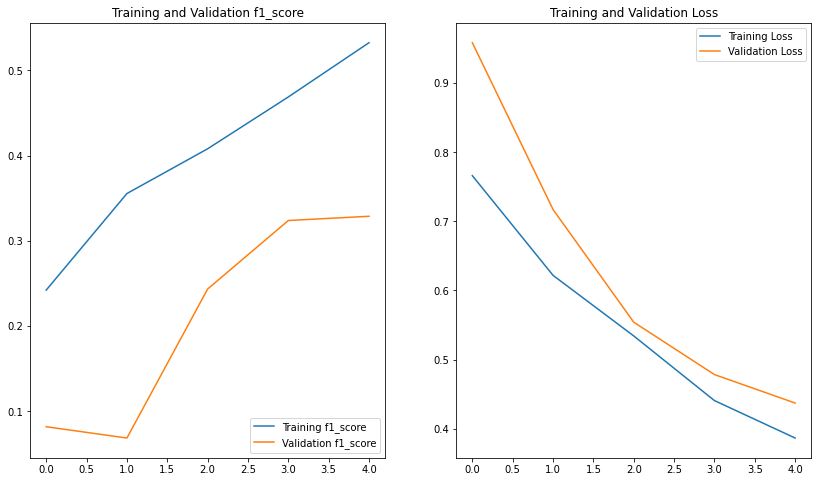

In [17]:
# Plotting accuracy and val loss
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training f1_score')
plt.plot(epochs_range, val_acc, label='Validation f1_score')
plt.legend(loc='lower right')
plt.title('Training and Validation f1_score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.save('./my_model.h5')

### MOBILENET

In [19]:
def create_model():
    pre_trained_model = tf.keras.applications.MobileNetV2(input_shape = (HEIGHT,WIDTH, CHANNELS), 
                                include_top = False, 
                                weights = "imagenet")

    # Setting pretrained model to no trainable
    pre_trained_model.trainable = False

    last_layer = pre_trained_model.get_layer('out_relu')
    
    last_output = last_layer.output

    x = layers.GlobalMaxPooling2D()(last_output)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)    
    x = layers.Dense(num_classes, activation='sigmoid',dtype='float32')(x)           

    model = Model( pre_trained_model.input, x )
    return model

In [20]:
tf.keras.backend.clear_session()

with strategy.scope():
    
    model = create_model()
    model = compile_model(model, lr=1e-3)
   
    
    
    history = model.fit(
                        train_ds,
                        epochs=EPOCHS,
                        
                        validation_data = val_ds,
                        verbose=VERBOSE,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        validation_steps=VALID_STEPS
                       )
                       

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/5
19/19 [==============================] - 15s 374ms/step - loss: 0.8111 - f1_score: 0.2259 - val_loss: 0.9662 - val_f1_score: 0.3064
Epoch 2/5
19/19 [==============================] - 3s 144ms/step - loss: 0.5980 - f1_score: 0.4100 - val_loss: 0.7605 - val_f1_score: 0.4108
Epoch 3/5
19/19 [==============================] - 2s 125ms/step - loss: 0.4584 - f1_score: 0.5683 - val_loss: 0.5614 - val_f1_score: 0.5302
Epoch 4/5
19/19 [==============================] - 2s 127ms/step - loss: 0.3625 - f1_score: 0.6287 - val_loss: 0.4548 - val_f1_score: 0.5542
Epoch 5/5
19/19 [==============================] - 2s 126ms/step - loss: 0.2949 - f1_score: 0.6820 - val_loss: 0.3966 - val_f1_score: 0.5713


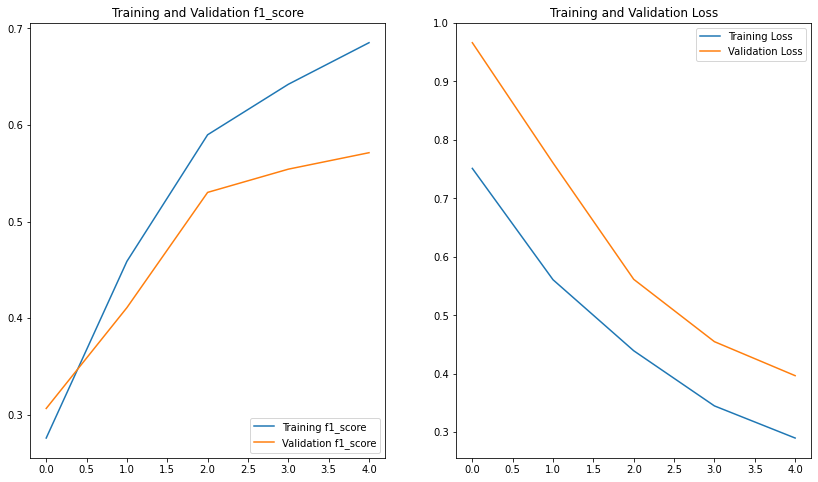

In [21]:
# Plotting accuracy and val loss
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training f1_score')
plt.plot(epochs_range, val_acc, label='Validation f1_score')
plt.legend(loc='lower right')
plt.title('Training and Validation f1_score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### RESNET 50

In [22]:
def create_model():
    pre_trained_model = tf.keras.applications.ResNet50(input_shape = (HEIGHT,WIDTH, CHANNELS), 
                                include_top = False, 
                                weights = "imagenet")

    # Setting pretrained model to no trainable
    pre_trained_model.trainable = False

    last_layer = pre_trained_model.get_layer('conv5_block3_out')
    
    last_output = last_layer.output

    x = layers.GlobalMaxPooling2D()(last_output)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)    
    x = layers.Dense(num_classes, activation='sigmoid',dtype='float32')(x)           

    model = Model( pre_trained_model.input, x )
    return model

In [23]:
#EPOCHS = 10
VERBOSE =1

tf.keras.backend.clear_session()

with strategy.scope():
    
    model = create_model()
    model = compile_model(model, lr=1e-3)
   
    
    
    history = model.fit(
                        train_ds,
                        epochs=EPOCHS,
                        
                        validation_data = val_ds,
                        verbose=VERBOSE,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        validation_steps=VALID_STEPS
                       )
                       

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/5
19/19 [==============================] - 20s 513ms/step - loss: 0.7698 - f1_score: 0.1480 - val_loss: 1.6324 - val_f1_score: 0.0329
Epoch 2/5
19/19 [==============================] - 2s 130ms/step - loss: 0.5535 - f1_score: 0.2841 - val_loss: 1.1935 - val_f1_score: 0.0329
Epoch 3/5
19/19 [==============================] - 2s 130ms/step - loss: 0.4322 - f1_score: 0.3170 - val_loss: 0.9425 - val_f1_score: 0.0329
Epoch 4/5
19/19 [==============================] - 2s 130ms/step - loss: 0.4020 - f1_score: 0.3601 - val_loss: 0.8801 - val_f1_score: 0.1019
Epoch 5/5
19/19 [==============================] - 2s 130ms/step - loss: 0.3895 - f1_score: 0.4096 - val_loss: 0.7320 - val_f1_score: 0.0780


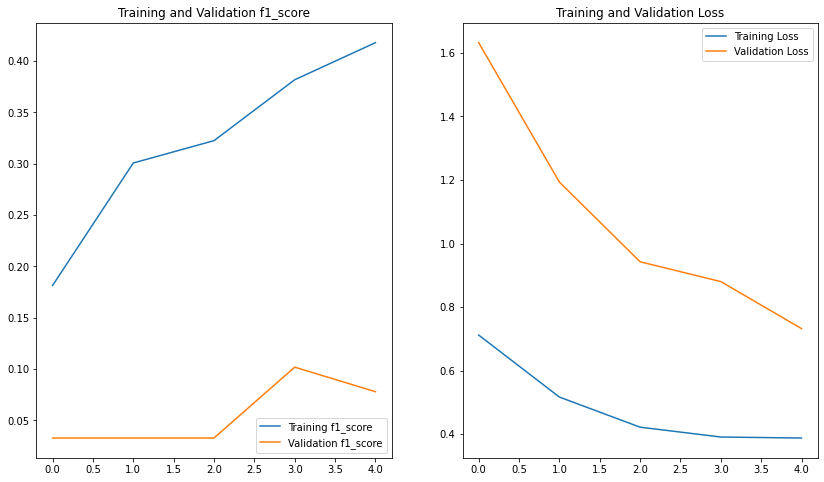

In [24]:
# Plotting accuracy and val loss
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training f1_score')
plt.plot(epochs_range, val_acc, label='Validation f1_score')
plt.legend(loc='lower right')
plt.title('Training and Validation f1_score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Pre-trained models conclusion

MobileNet model seems to have better results

## MOBILNET Tuner

We will use Keras tuner Hyperband to tune :
* A dropout layer (as there is clear overfitting)
* Learning rate


In [25]:
def model_builder(hp):
    pre_trained_model = tf.keras.applications.MobileNetV2(input_shape = (HEIGHT,WIDTH, CHANNELS), 
                                include_top = False, 
                                weights = "imagenet")

    # Setting pretrained model to no trainable
    pre_trained_model.trainable = False

    last_layer = pre_trained_model.get_layer('out_relu')
    
    last_output = last_layer.output

    x = layers.GlobalMaxPooling2D()(last_output)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)    
    # Tune a drop out layer
    # Choose an optimal value from 0.0 to 0.5
    x = layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.2))(x)
    x = layers.Dense(num_classes, activation='sigmoid',dtype='float32')(x)           

    model = Model( pre_trained_model.input, x )

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])

    loss = tf.keras.losses.BinaryCrossentropy()

    metrics = tfa.metrics.F1Score(num_classes = num_classes,
                                    average = "macro",name = "f1_score") 


    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss=loss,
            metrics=[metrics])

    return model


### Keras hyperband tuner

In [26]:
import kerastuner as kt

tf.keras.backend.clear_session()

tuner = kt.Hyperband(
    model_builder,
    objective= kt.Objective("val_f1_score", direction="max"),
    max_epochs=10,
    distribution_strategy=strategy    )

In [27]:
print("Search space summary")
tuner.search_space_summary()

Search space summary
Search space summary
Default search space size: 2
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}


In [28]:
tuner.search(train_ds, epochs=5,steps_per_epoch = STEPS_PER_EPOCH,validation_steps = STEPS_PER_EPOCH,
             validation_data = val_ds)



Trial 27 Complete [00h 01m 03s]
val_f1_score: 0.6154396533966064

Best val_f1_score So Far: 0.6154396533966064
Total elapsed time: 00h 15m 15s


In [29]:
print("Search results summary")
tuner.results_summary()

Search results summary
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_f1_score', direction='max')
Trial summary
Hyperparameters:
dropout: 0.0
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6154396533966064
Trial summary
Hyperparameters:
dropout: 0.4
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: e05325bd77e8abf02c8cbb66f8efd241
Score: 0.6153624057769775
Trial summary
Hyperparameters:
dropout: 0.1
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 91f34bf7495e908642194044486e8949
Score: 0.5588573217391968
Trial summary
Hyperparameters:
dropout: 0.1
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 84d101c43049c6f4d7e220c5626ae5cd
Score: 0.5486882328987122
Trial summary
Hyperparameters:
dropout: 0.1
learning_rate: 0.01

In [30]:
# keeping best model
model = tuner.get_best_models()[0]

# Full data

We will now train the tuned model on the full dataset

## Data prep

In [31]:
class_dict = {
    'scab': 0,
    'frog_eye_leaf_spot' : 1,
    'rust' : 2,
    'complex' : 3,
    'powdery_mildew' : 4,
    "healthy" : 5
}
num_classes = len(class_dict)    
class_names = dict([(value, key) for key, value in class_dict.items()])
train["labels"] = train["labels"].map(lambda x : [i for i in x.split(" ")])
#train_df["labels"] = train_df["labels"].map(lambda x : x.split(" "))
train["labels"] = train["labels"].map(lambda x : [class_dict[i] for i in x])

train["path"] = TRAIN_PATH + train["image"]

train.head()

,image,labels,path
0,800113bb65efe69e.jpg,[5],gs://kds-11c1175113c7e0363eed35763490e88e87d10...
1,8002cb321f8bfcdf.jpg,"[0, 1, 3]",gs://kds-11c1175113c7e0363eed35763490e88e87d10...
2,80070f7fb5e2ccaa.jpg,[0],gs://kds-11c1175113c7e0363eed35763490e88e87d10...
3,80077517781fb94f.jpg,[0],gs://kds-11c1175113c7e0363eed35763490e88e87d10...
4,800cbf0ff87721f8.jpg,[3],gs://kds-11c1175113c7e0363eed35763490e88e87d10...


In [32]:
# splitting for a train and valid set

X_train, X_test, y_train, y_test = train_test_split(train["path"], train['labels'], test_size=0.2, random_state = 12,
                                                      stratify =  train['labels'] )

In [33]:
train_ds = pd.concat([X_train, y_train], axis = 1)
valid_ds = pd.concat([X_test, y_test], axis = 1)

files_ls = list(train_ds["path"])
labels = np.zeros((len(train_ds),num_classes))

for i,file in enumerate(train_ds.values):
    labels[i][train_ds.iloc[i]["labels"]] = 1
    
train_ds = tf.data.Dataset.from_tensor_slices((files_ls,labels))
train_ds = train_ds.map(process_img,num_parallel_calls=AUTO)


files_ls = list(valid_ds["path"])
labels = np.zeros((len(valid_ds),num_classes))

for i,file in enumerate(valid_ds.values):
    labels[i][valid_ds.iloc[i]["labels"]] = 1
    
val_ds = tf.data.Dataset.from_tensor_slices((files_ls,labels))
val_ds = val_ds.map(process_img,num_parallel_calls=AUTO)

STEPS_PER_EPOCH  = (len(train_ds))//BATCH_SIZE
VALID_STEPS = (len(val_ds))//BATCH_SIZE

train_ds = train_ds.cache().repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO)
val_ds = val_ds.cache().repeat().batch(BATCH_SIZE).prefetch(AUTO)
print("Data Pipeline achieved !")

Data Pipeline achieved !


### Callbacks

In [34]:
# Create a callback that saves the model's weights

checkpoint_dir = "./raw_model.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1,
                                                 monitor= "val_f1_score",
        mode='max')

# Create a callback that stops fitting when val loss do not decrease
callback = tf.keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=10, mode='max')

reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= "val_f1_score",
        mode='max',
        factor=0.1,
        patience=2,
        verbose=1
    )

callbacks=[callback,cp_callback,reducelr]

## Training 

In [35]:

EPOCHS = 100

history = model.fit(train_ds,
        epochs=EPOCHS,
        validation_data = val_ds,
        verbose=VERBOSE,
        steps_per_epoch = STEPS_PER_EPOCH,
        validation_steps=STEPS_PER_EPOCH,
        callbacks = callbacks)

Epoch 1/100
232/232 [==============================] - 754s 3s/step - loss: 0.2937 - f1_score: 0.6385 - val_loss: 0.2384 - val_f1_score: 0.7277

Epoch 00001: val_f1_score improved from -inf to 0.72775, saving model to ./raw_model.h5
Epoch 2/100
232/232 [==============================] - 30s 129ms/step - loss: 0.2558 - f1_score: 0.6965 - val_loss: 0.2306 - val_f1_score: 0.7301

Epoch 00002: val_f1_score improved from 0.72775 to 0.73006, saving model to ./raw_model.h5
Epoch 3/100
232/232 [==============================] - 30s 128ms/step - loss: 0.2427 - f1_score: 0.7091 - val_loss: 0.2272 - val_f1_score: 0.7375

Epoch 00003: val_f1_score improved from 0.73006 to 0.73754, saving model to ./raw_model.h5
Epoch 4/100
232/232 [==============================] - 30s 129ms/step - loss: 0.2333 - f1_score: 0.7251 - val_loss: 0.2268 - val_f1_score: 0.7390

Epoch 00004: val_f1_score improved from 0.73754 to 0.73900, saving model to ./raw_model.h5
Epoch 5/100
232/232 [==============================] 

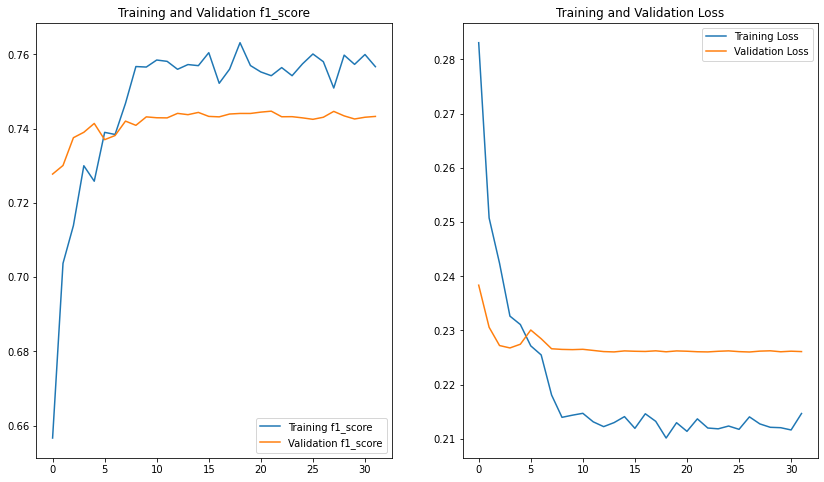

In [36]:
# Plotting accuracy and val loss
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training f1_score')
plt.plot(epochs_range, val_acc, label='Validation f1_score')
plt.legend(loc='lower right')
plt.title('Training and Validation f1_score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
model.load_weights(checkpoint_dir)

model.save('./my_model.h5')

### Predictions

We now want to make some prediction on a small sample of images.

In [38]:
# loading the model
new_model = tf.keras.models.load_model('./my_model.h5')

In [39]:
# Taking 9 images as sample

train = pd.read_csv("../input/plant-pathology-2021-fgvc8/train.csv")

files_ls = tf.io.gfile.glob(TRAIN_PATH + '*.jpg')

from random import sample

files_ls_sample = sample(files_ls,9)

train["path"] = TRAIN_PATH  +  train["image"]

test_df = train[train["path"].isin(files_ls_sample)]

print("Sample shape")
test_df.shape



Sample shape


(9, 3)

In [40]:
test_df.head(9)

,image,labels,path
509,83907e6890bc6f79.jpg,frog_eye_leaf_spot,gs://kds-11c1175113c7e0363eed35763490e88e87d10...
2979,96e16b4238f71d07.jpg,scab,gs://kds-11c1175113c7e0363eed35763490e88e87d10...
3770,9f946a2a2d38d5b4.jpg,powdery_mildew,gs://kds-11c1175113c7e0363eed35763490e88e87d10...
8153,b9bf337cd22281c2.jpg,frog_eye_leaf_spot,gs://kds-11c1175113c7e0363eed35763490e88e87d10...
10647,c9c68d6632b46679.jpg,healthy,gs://kds-11c1175113c7e0363eed35763490e88e87d10...
12202,d5017e9fc074311f.jpg,healthy,gs://kds-11c1175113c7e0363eed35763490e88e87d10...
17380,f8fdc0a083e0cf87.jpg,healthy,gs://kds-11c1175113c7e0363eed35763490e88e87d10...
18048,fd1cc97e13c230c3.jpg,complex,gs://kds-11c1175113c7e0363eed35763490e88e87d10...
18238,fdec8cd44e88ca92.jpg,healthy,gs://kds-11c1175113c7e0363eed35763490e88e87d10...


In [41]:
# preprocessing without labels

def process_img_test(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = tf.image.resize(image, [HEIGHT,WIDTH])
    return image

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(files_ls_sample)
    .map(process_img_test
).batch(BATCH_SIZE)
)



In [42]:
# making predictions
predicts = new_model.predict(test_dataset) 

threshold = 0.5

def get_labels(prediction):
  pred = []
  idx = np.where(prediction>threshold)[0]
  for i in idx:
    pred.append(class_names[i])
  pred = ' '. join(pred)
  if len(pred) == 0:
    pred = []
    idx = np.argmax(prediction)
    pred.append(class_names[idx])
    pred = ' '. join(pred)
    return pred
  else :
    return pred

labels = []
for i in range(len(predicts)):
  pred = predicts[i]

  labels.append(get_labels(pred))
    
test_df["pred"] = labels

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Showing some predictions

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


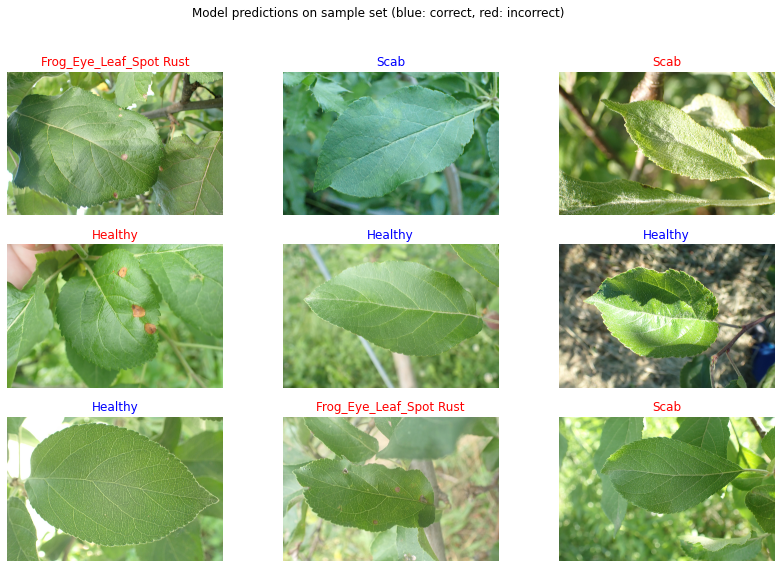

In [43]:
test_df["path"] = "../input/plant-pathology-2021-fgvc8/train_images/" + test_df["image"]

# Showing image sample
plt.figure(figsize=(14,9))
n=1
for i in test_df.index :
    plt.subplot(3,3,n)
    
    testImage = img.imread(test_df["path"][i])

    # displaying the image
    plt.imshow(testImage)
    color = "blue" if test_df["pred"][i] == test_df["labels"][i] else "red"
    
    plt.title(test_df["pred"][i].title(), color=color)
    plt.axis("off")
    n+=1
_ = plt.suptitle("Model predictions on sample set (blue: correct, red: incorrect)")